In [1]:
#Manejo de matrices y tablas
import numpy as np
import pandas as pd

#Estadistica y funciones matemáticas
import scipy.stats as st
from scipy.optimize import fmin
from scipy import integrate

#Graficas
import seaborn as sns
import plotly.graph_objects as go
import altair as alt
from altair_saver import save #ademas instalar en terminal: brew cask install chromedriver
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from matplotlib import animation, rc
from IPython.display import display, HTML, Markdown
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, HBox, VBox, Layout
from graphviz import Source, Digraph
import dot2tex as d2t
from latex import build_pdf
from mpl_toolkits.mplot3d import axes3d


# Métodos computacionales para obtener la posterior
Santiago Alonso-Díaz, PhD <br>
Universidad Javeriana

Ideal: soluciones analíticas (formulas)<br>
Realidad: muy difícil de conseguir <br>
Solución: métodos computacionales (algoritmos)

<center><img src="img/3_CB/MCMC_robot.svg" width = "1000" height = '1000'></center>

Es una métafora. Muchas preguntas:<br>
¿Qué es la montaña? <br>
¿Qué entiende el algoritmo por "abismo"?<br>
¿Dónde se inicia? <br>
¿Tiene que ir a las otras montañas?

<center><img src="img/3_CB/MCMC_robot.svg" width = "1000" height = '1000'></center>

# Intro. Markov

La data puede no ser normal. Por ejemplo, con varias modas:

<center><img src="img/3_CB/3modes.svg" width = "600" height = '600'></center>

Es data hipótetica, pero ¿qué piensan que puede ser cada moda?

¿Qué pasa si imponemos un modelo normal no jerárquico?<br>
 
<center><img src="img/3_CB/3modes_posterior.svg" width = "600" height = '600'></center>

No sirve. Y obtener una expresión matemática puede no ser fácil.


Métodos computacionales nos pueden ayudar a pensar modelos más elaborados.

Vamos a centrarnos en algoritmos `MCMC`.

Primero recordemos que significa que un proceso sea de tipo `Markov`

Proceso Markov (s: state):
$$p(s_1,s_2, s_3, ..., s_n) = p(s_1)p(s_2|s_1)p(s_3|s_2) ... p(s_n|s_{n-1}) $$


En lenguaje natural:

No hay memoria de toda la secuencia. Solo hay acceso al estado actual para determinar la probabilidad del siguiente estado.

Todo proceso Markoviano tiene transiciones de probabilidad de un estado al otro

<center><img src="img/3_CB/markov1.gv.svg" width = "650" height = '650'></center>


Otro ejemplo

<center><img src="img/3_CB/Monopolio.png" width = "400" height = '400'></center>

Otro ejemplo ... debate: ¿es el lenguaje Markoviano?

<center><img src="img/3_CB/markov2.gv.svg" width = "650" height = '650'></center>

# Bayes y Markov (MCMC)

| <img src="img/2_CB/Thomas_Bayes.gif" width = "200" height = '200'>  | <img src="img/3_CB/AAMarkov.jpg" width = "200" height = '200'> |
|:---:|:---:|
|     |     |


¿Qué tiene que ver esto con una posterior Bayesiana?

Un modelo de desigualdad en educación en puntajes debería incluir variables latentes escasas (Quarles, 2020): recursos sociales, académicos, emocionales, y económicos. <br>
¿Como tomar una muestra? Muestra: un puntaje, dada las variables. 

<center><img src="img/3_CB/3modes.svg" width = "400" height = '400'></center>

Problema: tomar muestras (valores) de modelos <br>
Solución: algoritmo MCMC (las probabilidades de transición y aceptar son el algoritmo)
<center><img src="img/3_CB/markov3.gv.svg" width = "650" height = '650'></center>

Acá una animación de un algoritmo MCMC en acción. <br>
Idea básica: se propone una muestra (markoviana) y algoritmo acepta o rechaza.

<center><img src="img/3_CB/MCMC_animation.gif" width = "651" height = '650'></center>

<p style = 'font-size: 15px'>Fuente: https://blog.stata.com/2016/11/15/introduction-to-bayesian-statistics-part-2-mcmc-and-the-metropolis-hastings-algorithm/ </p>

Aclaraciones iniciales:
* Podemos samplear posteriors no estandarizados (sin el denominador de Bayes).
* Usamos logaritmos para evitar over y underflows (productos son sumas en logaritmos).
* Pensemos MCMC como una estrategia para visitar "terreno", proporcional a su importancia (siguiente diapositiva)


Metafora del político (Kruschke, 2014). 

Problema: Dar un discurso en el Estadio Campin. La candidata quiere que el estadio se llene proporcional a la población de las localidades.

<center><img src="img/3_CB/localidades_bogota.jpg" width = "550" height = '550'></center>

Estrategia:

1. Empezar a reclutar en alguna localidad aleatoria.

2. Para ir a otra, lanzar una moneda norte-sur u oriente-occidente. Otro lanzamiento para subdirección (e.g. norte)

3. Si la localidad propuesta tiene más población, ir con certeza. Si tiene menos, ir probabilísticamente. Por ejemplo, si tiene 50% de la población ir con 50% de probabilidad a la nueva localidad, de lo contrario seguir en la actual.

4. De forma general, $Prob_{moverse} = min(\frac{poblacion_{propuesta}}{poblacion_{actual}},1)$

<center><img src="img/3_CB/localidades_bogota.jpg" width = "250" height = '250'></center>

Esta heurística es eficiente en el largo plazo: visitamos las localidades proporcional a su población.

Traducción metáfora:<br>
Localidades -> Regiones de la función <br>
Población localidad -> Nivel de la función en una región <br>
Individuo confirmado -> Muestra

<center><img src="img/3_CB/3Density.svg" width = "650" height = '650'></center>


Hay muchas versiones de MCMC (Gibbs, Metropolis, Hamiltonian). A nivel general, muchas comparten la siguiente estructura:

1. Posición inicial (muestra actual)
2. Propuesta a donde moverse (muestra propuesta)
3. Aceptar/rechazar propuesta basado en que tanto respeta la data y priors.
4. Si se acepta, moverse a la propuesta. Si se rechaza, seguir en posición actual.
5. Repetir desde paso 1.
6. Repetir 1-5 por iteraciones o muestras requeridas.

# Preambulo ejemplos

Los lenguajes como Python, R, Julia ya tienen funciones que nos permiten tomar muestras. 

Pienselas como ladrillos que nos van a permitir tomar muestras de posteriors complicados.

Actividad: busque en Internet cómo funcionan las funciones .pdf,.cdf,.rvs de scipy.stats:
* scipy.stats.norm.pdf; scipy.stats.norm.cdf; scipy.stats.norm.rvs
* scipy.stats.multivariate_normal.pdf; scipy.stats.multivariate_normal.cdf; scipy.stats.multivariate_normal.rvs
* scipy.stats.beta.pdf; scipy.stats.beta.cdf; scipy.stats.beta.rvs
* scipy.stats.dirichlet.pdf; scipy.stats.dirichlet.cdf; scipy.stats.dirichlet.rvs

# Ejemplo 1 MCMC: Gibbs Sampler

Vamos a ver dos ejemplos: Gibbs y Metropolis.

En la práctica, usaremos rutinas MCMC en paquetes python (PyMC, Edward). Pero vale la pena ver estos dos ejemplos por: 
* Clásicos
* Generar intuición de métodos MCMC

La imagen muestra la distribución real de unas variables <br>
El primer método MCMC a ver, para tomar muestras de espacios multidimensionales similares, es Gibbs. <br>
Veamos el caso multivariado normal.

<center><img src="img/3_CB/bivariate_normal.svg" width = "400" height = '400'></center>


Enfoquemonos en dos dimensiones: p(var1, var1). 

Pongamosle nombres a las variables: p(confianza, impaciencia). La imagen muestra que hay correlación negativa (e.g. Kidd, 2013).

<center><img src="img/3_CB/bivariate_normal.svg" width = "401" height = '400'></center>

La idea básica detrás de Gibbs:
* Suponga que conocemos pero es difícil tomar muestras de la distribución conjunta $p(confianza, impaciencia)$

* Suponga que es fácil tomarlas de las condicionadas: $p(confianza|impaciencia)$ y de $p(impaciencia|confianza)$. Por ejemplo, ambas son normales.

* El algoritmo hace lo siguiente:
    1. Pone valores iniciales a confianza y paciencia.
    2. Toma una muestra aleatoria de $p(confianza|impaciencia)$,
    3. Luego una de $p(impaciencia|confianza)$, 
    4. Repite 2 y 3 hasta tener suficientes muestras.


Para Gibbs necesitamos:
* Conjunta:

\begin{equation}
p(conf, impa) \sim N\left( 
\begin{bmatrix}
\mu_{conf} \\
\mu_{impa} 
\end{bmatrix}
\begin{bmatrix}
1 & \rho_{conf,impa} \\
\rho_{conf,impa} & 1 
\end{bmatrix}
\right)
\end{equation}

* Condicionales <span style = 'font-size: 10px'> (no lo demostramos acá, pero esta es la formula de las condicionadas para una multivariada normal)</span> 
<br><br>

\begin{equation}
p(conf|impa) \sim N(\mu_{conf} + \rho_{conf,impa}(impa-\mu_{impa}),1-\rho_{conf,impa}^2))
\end{equation}

\begin{equation}
p(impa|conf) \sim N(\mu_{impa} + \rho_{conf,impa}(conf-\mu_{conf}),1-\rho_{conf,impa}^2))
\end{equation}

Ahora solo resta aplicar el algoritmo.


In [2]:
#Ejemplo Gibbs sampler para multivariada normal bidimensional
#Parametros joint distribution
mean_joint = [6, 25] #[impaciencia, confianza]
corr = -0.6
cov = [[1, corr], [corr, 1]]

#Paso 1: valores iniciales
conf_samp = st.uniform.rvs(20,30,1)
impa_samp = st.uniform.rvs(0,10,1)
niter = 200 #número de iteraciones
joint = pd.DataFrame({'impaciencia': np.repeat(float('nan'),niter),
                     'confianza': np.repeat(float('nan'),niter)})
for i in range(niter):
    #Paso 2: samplear un valor aleatorio de confianza
    conf_samp = st.norm.rvs(mean_joint[1]+corr*(impa_samp-mean_joint[0]),1-corr**2,1)

    #Paso 3: samplear un valor aleatorio de impaciencia
    impa_samp = st.norm.rvs(mean_joint[0]+corr*(conf_samp-mean_joint[1]),1-corr**2,1)

    joint.loc[i,'impaciencia'] = impa_samp
    joint.loc[i,'confianza'] = conf_samp


El algoritmo hace un buen recorrido de todo el espacio

<center><img src="img/3_CB/Gibbs_animation-min.gif" width = "401" height = '400'></center>


En términos generales, con Gibbs:

* Se puede tomar muestras de cualquier distribución conjunta $p(\theta_1, \theta_2, ... \theta_n, data)$. No solo normal, lo anterior fue un ejemplo.

* Se necesita conocer las probabilidades condicionales de todas las variables, dado las demás.

* Es markoviano: el siguiente "paso" depende del estado actual (muestra actual). 

* Ventaja: siempre se aceptan las propuestas. Desventaja: hay que saber los condicionales



# Ejemplo 2 MCMC: Metropolis & Metropolis-Hastings

Gibbs es un caso particular de Metropolis-Hastings. La diferencia general con Gibbs:

* Necesita una distribución conocida para proponer valores (muestras) que el algoritmo acepta o rechaza.

* En Gibbs esa distribución eran los condicionales. 

* En Metropolis-Hastings pueden ser otras. De hecho, muchas versiones ni siquiera usan los condicionales.


Volvamos a nuestro problema favorito: Queremos saber la probabilidad de ocurrencia de un evento binario a partir de la data (e.g. ganar/perder, categoria 1/categoria 2, culpable / inocente, etc.). 

Solución: Bayes.

\begin{align}
p(\theta|data) &\propto p(data|\theta)p(\theta)\\
               &\propto Binomial(n, z, \theta)beta(\alpha,\beta)\\
\end{align}

Donde n es lanzamientos, z éxitos, $\theta$ probabilidad de éxito, $\alpha$, y $\beta$ parámetros de la prior


En una anterior imagen ya vimos el algoritmo Metropolis (el Metropolis-Hastings en siguientes diapositivas). 

Se proponen valores de una distribución normal que "salta". Se calcula un ratio r de la posterior de la propuesta y la actual (sin estandarizar). Se acepta o rechaza con unos criterios.

<center><img src="img/3_CB/MCMC_animation.gif" width = "651" height = '650'></center>

<p style = 'font-size: 15px'>Fuente: https://blog.stata.com/2016/11/15/introduction-to-bayesian-statistics-part-2-mcmc-and-the-metropolis-hastings-algorithm/ </p>

Sobre la distribución de propuesta q para Metropolis:
* Salta cuando se acepte un valor. En esta visualización, el centro de la normal se mueve a la propuesta $\theta^{*}$ (que fue aceptada).  
* Debe ser simétrica: $q(\theta^{*}|\theta) = q(\theta|\theta^{*})$. Evita sesgos (e.g. saltos mayores desde algunos puntos).

<center><img src="img/3_CB/MCMC_animation2.gif" width = "550" height = '550'></center>

<p style = 'font-size: 15px'>Fuente: https://blog.stata.com/2016/11/15/introduction-to-bayesian-statistics-part-2-mcmc-and-the-metropolis-hastings-algorithm/ </p>

 

Metropolis-Hastings (MH) es la version general. No requiere un distribución de propuesta q simétrica. Para compensar, el ratio r de posteriors p se cambia a un ratio de ratios. 

| Metropolis | Metropolis-Hastings |
|:--:|:--:|
| \begin{equation} \frac{p(\theta^{*}\|y)}{p(\theta\|y)} \end{equation} |  \begin{equation} \frac{p(\theta^{*}\|y) / q(\theta^{*}\|\theta)}{p(\theta\|y)/ q(\theta\|\theta^{*})} \end{equation}  |


Para ejemplificar MH, estimemos el promedio y varianza de un proceso gaussiano (e.g. puntajes en una prueba). 

El estimativo frecuentista es directo: el promedio y varianza de la data. Queremos el bayesiano: la creencia en forma de distribución de posibles parámetros dado los datos.

Podemos conseguir la formula dado que es gaussiano, pero tratemos con MH.

Primero generemos unos datos ...

In [3]:
# Metropolis-Hastings
# Datos 
tamano = 50000
mu_real = 50 #parámetro a inferir, imagine que no los conocemos.
sigma_real = 10 #parámetro a inferir, imagine que no los conocemos.
poblacion = np.random.normal(mu_real,sigma_real,tamano)
n = 150 #solo observamos n datos de la población
data = pd.DataFrame({'muestra': poblacion[np.random.randint(0, tamano, n)]})


In [4]:
#Graficas usando altair (permite grabarlas a html) (correr celda anterior)
#Tutorial en https://altair-viz.github.io/getting_started/overview.html
bins = 20
bar = alt.Chart(data).mark_bar().encode(
    alt.X("muestra", axis=alt.Axis(title="Variable"), bin=alt.Bin(maxbins=bins)),
    alt.Y('count()', axis=alt.Axis(title="Conteo"))
)

den_data = alt.Chart(data).transform_density(#transformaciones a la data
    density = 'muestra',
    counts = True,
    steps=bins
).mark_line( #tipo de gráfica
    color='red',
    opacity=.35,
    strokeWidth = 5
).encode(#detalles de los ejes
    alt.X('value:Q', axis=alt.Axis(title="Variable")),
    alt.Y('density:Q', axis=alt.Axis(title="Densidad (kde)")),
).properties(width=400, height=300)

#both = (den_data).configure_axis(titleFontSize=20, labelFontSize = 15, grid=False) 
both = (bar).configure_axis(titleFontSize=20, labelFontSize = 15, grid=False)
#save(both, "img/3_CB/Metropolis_data.svg", method='selenium', webdriver='chrome') # si no sirve, salvar con los 3 punticos
#save(both, "img/3_CB/Metropolis_data.html") #salva la gráfica en html

In [5]:
#Conteos y densidad de la data (kernel estimate)
both

alt.Chart(...)

Ahora recordemos paso a paso el algoritmo:
1. Defina distribuciones likelihood y prior
2. Defina una distribución de propuesta $q(\theta)$
3. Tome una muestra de $q(\theta)$. Esa muestra es la propuesta $\theta^{*}$
4. Calcule el ratio de ratios $\frac{p(\theta^{*}|y) / q(\theta^{*}|\theta)}{p(\theta|y)/ q(\theta|\theta^{*})}$
5. Acepte o rechaze $\theta^{*}$. Si acepta, mueva $q(\theta)$. Si rechaza no se mueva.
6. Repita 1 a 4 por la iteraciones o muestras deseadas.

In [6]:
##### Paso 1
#Prior & likelihood
def log_prior(pars):
    #Priors 
    #    mean: uniforme
    #    std. dev: uniform (positiva)
    #Supuesto: parámetros son independientes (multiplicar; en log sumar)
    #Input: pars[0] = mean, pars[1] = std. dev
    #Output: log. density  
    log_prob_mu = st.uniform.logpdf(pars[0], -100, 200)
    log_prob_sd = st.uniform.logpdf(pars[1], 0, 100)   
    return log_prob_sd + log_prob_mu
def log_lik_normal(pars,data):
    #Input: pars[0] = mean, pars[1] = std. dev, data = muestra
    #Output: log. density
    return np.sum(st.norm.logpdf(data, pars[0], pars[1]))

In [7]:
##### Paso 2 & 3 
# Distribución de propuesta
class propuesta:
    #Con MH, no es necesario que sea simétrica.
    #Acá usamos diferentes std y densidades (truncada normal y normal)
    def __init__(self):
        self.scales = [7, 2] #desviaciones estandar   
    def rvs(self, pars):
        left_lim = 0 #limite para truncar la normal
        right_lim = 50
        a = (left_lim - pars[1]) / self.scales[1] 
        b = (right_lim - pars[1]) / self.scales[1]        
        rand_var = [st.norm.rvs(pars[0], self.scales[0], size=1), 
                    st.truncnorm.rvs(a=a, b=b, loc=pars[1], 
                                     scale=self.scales[1], size=1)]        
        return rand_var    
    def log_pdf(self, x, pars):
        mu_logpdf = st.norm.logpdf(x[0], pars[0], self.scales[0]) 
        left_lim = 0 #limite para truncar la normal
        right_lim = 50
        a = (left_lim - pars[1]) / self.scales[1]
        b = (right_lim - pars[1]) / self.scales[1]
        sd_logpdf = st.truncnorm.logpdf(x[1], a=a, b=b, loc=pars[1], 
                                        scale=self.scales[1]) 
        return sd_logpdf + mu_logpdf

In [8]:
##### Paso 4 & 5
# Ratio de ratios y aceptar
def aceptar(x, x_nuevo, data):
    # Posteriors (sin estandarizar)
    posterior_nuevo = log_prior(x_nuevo)+log_lik_normal(x_nuevo, data) 
    posterior_actual = log_prior(x)+log_lik_normal(x, data)
    # Propuesta
    propuesta_nuevo = propuesta().log_pdf(x_nuevo, x)
    propuesta_actual = propuesta().log_pdf(x, x_nuevo)
    # Ratios
    ratio1 = posterior_nuevo - propuesta_nuevo #Resta por que estamos con logaritmos
    ratio2 = posterior_actual - propuesta_actual
    ratio_de_ratios = ratio1-ratio2 #Resta por que estamos con logaritmos
    # Aceptar
    u = st.uniform.rvs(0, 1, size = 1)
    acceptance_prob = np.min([1, np.exp(ratio_de_ratios)]) #exp para transformar logaritmos
    if u<acceptance_prob:
        return True
    else:
        return False
Metropolis

In [9]:
##### Paso 6
# Repita
def metropolis_hastings(par_inicial, iteraciones, data):
    x = par_inicial
    aceptado = []
    rechazado = []   
    for i in range(iteraciones):
        x_nuevo =  propuesta().rvs(x)  
        if aceptar(x, x_nuevo, data):
            x = x_nuevo
            aceptado.append(x_nuevo)
        else:
            rechazado.append(x_nuevo)                               
    return np.array(aceptado), np.array(rechazado) 

In [10]:
##### Resultados
#Cadena 1
par_inicial, iteraciones = [data.mean(), data.std()], 5000
A1, R1 = metropolis_hastings(par_inicial, iteraciones, data)
#Cadena 2
par_inicial, iteraciones = [4, 1], 5000
A2, R2 = metropolis_hastings(par_inicial, iteraciones, data)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


In [11]:
def my_MH_plot(A1, A2):
    print("Info. cadena 1.", 
      '\n95% HDI promedio: [', round(np.percentile(A1[:,0],[2.5])[0],2), ',', 
          round(np.percentile(A1[:,0],[97.5])[0],2),']',
      '\n95% HDI desv. est: [', round(np.percentile(A1[:,1],[2.5])[0],2), ',', 
          round(np.percentile(A1[:,1],[97.5])[0],2),']',
      '\naccept:', A1.shape[0]/iteraciones)
    print("\nInfo. cadena 2. ", 
      '\n95% HDI promedio: [', round(np.percentile(A2[:,0],[2.5])[0],2), ',', 
          round(np.percentile(A2[:,0],[97.5])[0],2),']',
      '\n95% HDI desv. est: [', round(np.percentile(A2[:,1],[2.5])[0],2), ',', 
          round(np.percentile(A2[:,1],[97.5])[0],2),']',
      '\naccept:', A2.shape[0]/iteraciones)
    fig, ax = plt.subplots(2,2, figsize=[7,5])
    ax[0,0].plot(np.arange(A1.shape[0]), A1[:,0])
    ax[0,0].set_title('Promedio \n (cadena 1)')
    ax[0,1].plot(np.arange(A1.shape[0]), A1[:,1])
    ax[0,1].set_title('Desv. Estandar \n (cadena 1)');
    ax[1,0].plot(np.arange(A2.shape[0]), A2[:,0])
    ax[1,0].set_title('Promedio \n (cadena 2)')
    ax[1,1].plot(np.arange(A2.shape[0]), A2[:,1])
    ax[1,1].set_title('Desv. Estandar \n (cadena 2)');
    plt.tight_layout();

Info. cadena 1. 
95% HDI promedio: [ 47.69 , 51.41 ] 
95% HDI desv. est: [ 8.85 , 11.52 ] 
accept: 0.0532

Info. cadena 2.  
95% HDI promedio: [ 46.04 , 51.36 ] 
95% HDI desv. est: [ 8.67 , 11.46 ] 
accept: 0.0662


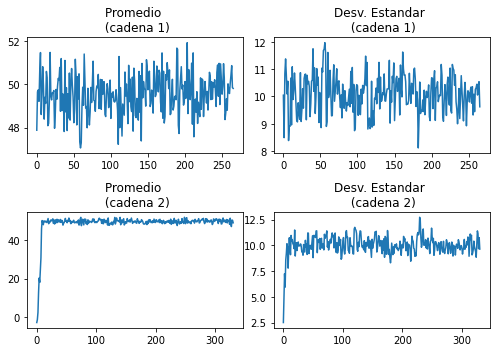

In [12]:
# Convergen ambas cadenas. Hay tests pero se puede ver.  
# Las trazas gravitan alredor de los mismos valores (pero baja aceptación)
my_MH_plot(A1, A2) #Note el "burn-in" al comienzo

In [13]:
data_mcmc = pd.DataFrame({'promedio': np.concatenate((A1[:,0],A2[:,0]))[:,0],
                         'desv_est':  np.concatenate((A1[:,1],A2[:,1]))[:,0]})
def my_alt_plot(var, ext, title = ''):    
    den = alt.Chart(data_mcmc).transform_density(#transformaciones a la data
        density = var, extent = ext, counts = True, steps=bins
    ).mark_line( #tipo de gráfica
        color='green', opacity=.75, strokeWidth = 5
    ).encode(#detalles de los ejes
        alt.X('value:Q', axis=alt.Axis(title=var)),
        alt.Y('density:Q', axis=alt.Axis(title="Densidad")),
    ).properties(
        width=250, height=250, title = title
    )

    return den
mcmc_den_p = my_alt_plot('promedio', [46,53], title = 'Posterior promedio')
mcmc_den_e = my_alt_plot('desv_est', [6.5,12], title = 'Posterior desv. est.')
plot = (mcmc_den_p|mcmc_den_e).configure_axis(
    titleFontSize=20, labelFontSize = 15, grid=False
).configure_title(
    fontSize=24
)

In [14]:
# Resultados (en forma de distribución, ambas cadenas)
plot

alt.HConcatChart(...)

"Todos los modelos están mal, algunos son útiles" (Box,1976)

¿Predice nuestro modelo la data? <br>
*Posterior predictive check* ($y^{rep}$: valor simulado; $y$: data; $\theta$: parámetros)

$$p(y^{rep}|y) = \int p(y^{rep}|\theta) p(\theta|y) d\theta $$

En lenguaje natural (casi): <br> 
En la integral, está el likelihood (1er termino) y posterior (2do). La implementamos con valores aleatorios de los parámetros $\theta$.

In [15]:
# Posterior predictive check
n_rep = 5000 
y_rep = []
for n in range(n_rep):
    #posterior (2do termino integral)
    idx = np.random.randint(data_mcmc.shape[0])
    prom_rep = data_mcmc.loc[idx,'promedio']
    idx = np.random.randint(data_mcmc.shape[0])
    desv_est_rep = data_mcmc.loc[idx,'desv_est']
    
    #likelihood (1er termino integral)
    y_rep.append(st.norm.rvs(prom_rep, desv_est_rep, size=1))


In [16]:
data_ppc = pd.DataFrame({'y_rep':np.array(y_rep)[:,0]}) 
den_ppc = alt.Chart(data_ppc).transform_density(#transformaciones a la data
        density = 'y_rep', extent = [20,80], counts = True, steps=bins
    ).mark_line( #tipo de gráfica
        color='green', opacity=.75, strokeWidth = 5
    ).encode(#detalles de los ejes
        alt.X('value:Q', axis=alt.Axis(title='y_rep')),
        alt.Y('density:Q', axis=alt.Axis(title="Densidad (kde)")),
    ).properties(
        width=250, height=250, title = 'PPC'
    )
plot_ppc_data = (den_ppc | den_data.properties(
    width=250, height=250, title = 'Data')
).configure_axis(
    titleFontSize=20, labelFontSize = 15, grid=False
).configure_title(
    fontSize=24
)

In [17]:
plot_ppc_data

alt.HConcatChart(...)

¿Metropolis-Hastings siempre converge a la posterior?

Respuesta corta: sí, el algoritmo converge cuando se cadena se hace bien (aunque puede demorarse). Respuesta larga, ver capitulo 7, Kruschke, 2da edición. 


¿Metropolis-Hastings siempre converge a la posterior?

Intuición. Tenemos la posterior $\theta=0.15$. Esta cadena converge a la posterior.

<center><img src="img/3_CB/mcmc_diagram.svg" width = "350" height = '350'></center>
<p style = 'font-size: 10px'>Fuente: https://people.duke.edu/~ccc14/sta-663/MCMC.html </p>

Converge si la cadena es:
* Irreducible (se puede ir a cualquier estado)
* Aperiodica (no nos quedamos en un loop entre estados)
* Recurrente (el tiempo de volver a un estado dado es finito)

# Herramienta complementaria: gradient descent  

Objetivo: obtener el posterior

Solución anterior: método estocástico (Markov + Montecarlo)

Solución complementaria: seguir un gradiente


¿Qué es gradient descent (ascent)?<br>
Metáfora alpinista (punto más alto) o urbanista (punto más bajo)

<center><img src="img/3_CB/3D_panorama.svg" width = "500" height = '500'></center>


El algoritmo para descent (minimizar) se ve algo así:
* Calcular el gradiente (pendiente) negativo de la función en la posición actual: $\nabla f(x_k)$

* Moverse en dirección del gradiente negativo.

Veamos la implementación de github.com/dtnewman/ con:

$$f(x) = x^3 - 2x^2+2$$

In [20]:
fig, ax = plt.subplots(1,1, figsize=[5,4.5]);
f = lambda x: x**3-2*x**2+2  
x = np.linspace(-1,2.5,1000)
ax.plot(x, f(x), lw = 3);
ax.set_title('Encontrar el mínimo (local)', fontsize=25);
#fig.savefig("img/3_CB/Gradient_Desc.svg"), plt.close();
plt.close()

<center><img src="img/3_CB/Gradient_Desc.svg" width = "400" height = '400'></center>

In [21]:
# Código 2D gradient descent github.com/dtnewman/stochastic_gradient_descent/

def f_prime(x): #derivada de nuestra función
    return 3*x**2-4*x

x_old,  x_new = 0, 2.5 #posición inicial
n_k = 0.01 #tamaño del paso
precision = 0.001
x_list, y_list = [x_new], [f(x_new)]    
while abs(x_new - x_old) > precision:       
    x_old = x_new
    s_k = -f_prime(x_old)
    x_new = x_old + n_k * s_k #La "fuerza" del movimiento depende del gradiente
    x_list.append(x_new), y_list.append(f(x_new))        


In [22]:
#Plot
def animate(i, x_list):
    idx = int(i)
    ax.plot(x_list[i], f(x_list[i]),'ro')
    if idx>0:
        x = x_list[(idx-1):(idx+1)]
        y = [f(x[0]),f(x[1])]
        ax.plot(x,y,'r')
fig, ax = plt.subplots(1,1, figsize=[7,7]);
ax.set_title('Encontrar el mínimo (local)', fontsize=25)
x = np.linspace(-0.75,2.5,1000)
ax.plot(x, f(x), lw = 3);
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, interval = 500, 
                               frames = len(x_list), blit=False, fargs = ([x_list]))
writer = animation.PillowWriter(fps=5)
#anim.save('img/3_CB/Gradient_animation.gif', writer = writer); #Compress online
plt.close()

<center><img src="img/3_CB/Gradient_animation.gif" width = "350" height = '350'></center>

¿Podemos acelerar el algoritmo? 

Sí. Podemos hacer el paso adaptativo. 

En el siguiente ejemplo hacemos "trampa" con una función minimizadora de Python. Lo importante es ver que se puede ser creativo en cómo explorar el espacio de la función.

In [23]:
# Pasamos esta función a un minimizador (fmin)
def f2(n,x,s):
    #n: paso; fmin cambia este para minimizar y
    #s: gradiente; x: coordenada x
    x = x + n*s #desplazamiento en x
    y = f(x) #y (a minimizar)
    return y 

x_old,  x_new = 0, 2.5 #posición inicial
n_k_init = 0.1 #tamaño del paso (valor inicial a fmin)
x_list, y_list = [x_new], [f(x_new)]
while abs(x_new - x_old) > precision:
    x_old = x_new
    s_k = -f_prime(x_old)   
    
    # use scipy fmin function to find ideal step size.
    n_k = fmin(f2,n_k_init,(x_old,s_k), full_output = False, disp = False)
    
    x_new = x_old + n_k * s_k
    x_list.append(x_new)
    y_list.append(f(x_new))

In [24]:
fig, ax = plt.subplots(1,1, figsize=[7,7]);
ax.set_title('Encontrar el mínimo (local)\n adaptativo', fontsize=25)
x = np.linspace(-0.75,2.5,1000)
ax.plot(x, f(x), lw = 3);
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, interval = 500, 
                               frames = len(x_list), blit=False, fargs = ([x_list]))
writer = animation.PillowWriter(fps=5)
#anim.save('img/3_CB/Gradient_adapt_animation.gif', writer = writer); #Compress online
plt.close()

|<img src="img/3_CB/Gradient_animation.gif" width = "300" height = '300'>|<img src="img/3_CB/Gradient_adapt_animation.gif" width = "300" height = '300'>|
|:-:|:-:|
|||

Gradient descent no asegura encontrar mínimos (máximos) globales, solo locales.

Podemos buscar óptimos (locales) de cualquier función. Por ejemplo, de una función de minimos cuadrados ordinarios (OLS, por sus siglas en inglés):
$${1 \over m} \sum\limits_{i=1}^m (h_\beta(x_i)-y_i)^2$$

Puede haber varios $\beta$. Es el mismo algoritmo pero con derivadas parciales.

¿Qué tiene que ver con Bayes?

La posterior $p(\theta_1,...\theta_n|data)$ es una función multidimensional. Hay algoritmos MCMC que explotan gradientes, por ejemplo Hamiltonian MCMC. 

<center><img src="img/3_CB/3D_panorama.svg" width = "400" height = '400'></center>

El MCMC hamiltoniano es popular. Esta es la intuición: recorre el posterior usando gradientes y momentum.

<center><img src="img/3_CB/Hamiltonian_MCMC_1.svg" width = "475" height = '475'></center>

Fuente: Betancourt (2018)

# Variational inference

Metáfora pintor (minimizar distancia)
<center><img src="img/3_CB/triple_self_portrait.jpg" width = "400" height = '400'></center>
<p style = 'font-size: 15px'>Fuente: https://displate.com/tonycenteno/displates </p>


Problema: algunas posterior son difíciles de analizar matemáticamente o recorrer con MCMC.

Solución de variational inference: Escoger una distribución lo suficientemente parecida y que sea fácil de samplear. Esa distribución la llaman variational.

¿Qué significa que dos distribuciones sean parecidas?
<center><img src="img/3_CB/KL_1.svg" width = "600" height = '600'></center>


Varios criterios. Usaremos divergencia Kullback–Leibler (KL)

$$ D_{KL} (q(z)\|p(z|x)) = \int_z q(z) log \left(\frac{q(z)}{p(z|x)} \right)dz$$

$q(z)$: Candidata (variational) <br>
$p(z|x)$: Posterior 

Positiva y asimétrica: 

\begin{equation} D_{KL} (q(z)\|p(z|x)) \ne D_{KL} (p(z|x)\|q(z))\end{equation}



Es el promedio de $log \left(\frac{q(z)}{p(z|x)} \right)$, ponderando por $q(z)$

$$ D_{KL} (q(z)\|p(z|x)) = \int_z q(z) log \left(\frac{q(z)}{p(z|x)} \right)dz$$

$log \left(\frac{q(z)}{p(z|x)} \right) = log(p(x)) - log(p(z|x))$. Es decir, es el promedio de la diferencia de (log) probabilidades de z. 

Mide cuanta información se pierde cuando usamos p para aproximar q. 

Objetivo: minimizar esta cantidad (e.g. con gradient descent).


In [25]:
#Ejemplo simple
def KL(x, p, q):
    return p(x) * np.log( p(x) / q(x) ) 
p = st.norm(10,2).pdf
q = st.norm(18,4).pdf
kl_int, err = integrate.quad(KL,-30,30,args=(q,p))
print("La divergencia KL entre q y p es: ", round(kl_int,4))

La divergencia KL entre q y p es:  8.7396


<center><img src="img/3_CB/KL_2.svg" width = "600" height = '600'></center>

Queremos minimizar la divergencia entre la posterior $p$ y la candidata $q$, que es más fácil de samplear. 

Pero primero, escribamos la divergencia KL de otra forma.

\begin{aligned}
D_{\text{KL}} \big( q(\boldsymbol{z}) || p(\boldsymbol{z} | \boldsymbol{x}) \big) &= \int\limits_{\boldsymbol{z}} q(\boldsymbol{z}) \log \Big[ \frac{q(\boldsymbol{z})}{p(\boldsymbol{z} | \boldsymbol{x})} \Big] d\boldsymbol{z} \\
\end{aligned}
 

Apliquemos propiedad de logaritmos y dividamos la integral

\begin{aligned}
&= \int\limits_{\boldsymbol{z}} \Big[ q(\boldsymbol{z}) \log q(\boldsymbol{z}) \Big] d\boldsymbol{z} - \int\limits_{\boldsymbol{z}} \Big[ q(\boldsymbol{z}) \log p(\boldsymbol{z} | \boldsymbol{x}) \Big] d\boldsymbol{z}  
\end{aligned}


Son promedios, ponderados por $q(z)$

\begin{aligned}
&= \mathbb{E}_{q} \big[ \log q(\boldsymbol{z}) \big] - \mathbb{E}_{q} \big[ \log p(\boldsymbol{z} | \boldsymbol{x}) \big] 
\end{aligned}



Apliquemos la definición de probabilidad condicional

\begin{aligned}
&= \mathbb{E}_{q} \big[ \log q(\boldsymbol{z}) \big] - \mathbb{E}_{q} \big[ \log p(\boldsymbol{z} | \boldsymbol{x}) \big] \\
&= \mathbb{E}_{q} \big[ \log q(\boldsymbol{z}) \big] - \mathbb{E}_{q} \bigg[ \log \Big[ \frac{p(\boldsymbol{x}, \boldsymbol{z}) }{p(\boldsymbol{x})} \Big] \bigg] 
\end{aligned}


Propiedad de logaritmos 

\begin{aligned}
&= \mathbb{E}_{q} \big[ \log q(\boldsymbol{z}) \big] - \mathbb{E}_{q} \big[ \log p(\boldsymbol{x}, \boldsymbol{z}) \big] + \mathbb{E}_{q} \big[ \log p(\boldsymbol{x}) \big]
\end{aligned}


$\mathbb{E}_{q} \big[ \log p(\boldsymbol{x}) \big] = \log p(\boldsymbol{x})$ i.e. el prior de x (i.e. data) no depende de q(z) por definición

\begin{aligned}
&= \mathbb{E}_{q} \big[ \log q(\boldsymbol{z}) \big] - \mathbb{E}_{q} \big[ \log p(\boldsymbol{x}, \boldsymbol{z}) \big] + \log p(\boldsymbol{x})
\end{aligned}

Tenemos entonces que la divergencia KL es:

\begin{aligned}
D_{\text{KL}} \big( q(\boldsymbol{z}) || p(\boldsymbol{z} | \boldsymbol{x}) \big) &= \mathbb{E}_{q} \big[ \log q(\boldsymbol{z}) \big] - \mathbb{E}_{q} \big[ \log p(\boldsymbol{x}, \boldsymbol{z}) \big] + \log p(\boldsymbol{x})
\end{aligned}

Ahora definamos evidence lower bound (ELBO) como una reorganización de los dos primeros términos:

\begin{aligned}
ELBO &= \mathbb{E}_{q} \big[ \log p(\boldsymbol{x}, \boldsymbol{z}) \big] - \mathbb{E}_{q} \big[ \log q(\boldsymbol{z}) \big] 
\end{aligned}

La divergencia KL queda así:

\begin{aligned}
D_{\text{KL}} \big( q(\boldsymbol{z}) || p(\boldsymbol{z} | \boldsymbol{x}) \big) &= -ELBO + log(p(x)
\end{aligned}



$\log p(\boldsymbol{x})$ es una constante, no afecta la minimización. Es decir, *maximizar ELBO* es lo mismo que minimizar la divergencia KL

\begin{aligned}
D_{\text{KL}} \big( q(\boldsymbol{z}) || p(\boldsymbol{z} | \boldsymbol{x}) \big) &= -ELBO + log(p(x)
\end{aligned}


Se llama evidence lower bound por que es un limíte inferior del logaritmo de la evidencia 
($D_{\text{KL}}$ siempre es positivo)

\begin{aligned}
log(p(x) &= ELBO + D_{\text{KL}} \big( q(\boldsymbol{z}) || p(\boldsymbol{z} | \boldsymbol{x}) \big)\\
&\ge ELBO
\end{aligned}

La idea es maximizar ELBO respecto a los parámetros z. 

\begin{aligned}
ELBO &= \mathbb{E}_{q} \big[ \log p(\boldsymbol{x}, \boldsymbol{z}) \big] - \mathbb{E}_{q} \big[ \log q(\boldsymbol{z}) \big] 
\end{aligned}

$p(x,z)$ la tenemos. ¿Cómo escogemos $q(z)$? Mitad ciencia mitad arte. 

<center><img src="img/3_CB/triple_self_portrait.jpg" width = "300" height = '300'></center>
<p style = 'font-size: 15px'>Fuente: https://displate.com/tonycenteno/displates </p>


Una posibilidad es con mean-field variational family. 

$$ q(z_1, ... z_m) = \prod_{j=1}^{m} q(z_j)$$

Es decir, cada parámetro $z_j$ tiene su propia distribución $q(z_j)$ (e.g. normal) y se asumen independientes.

Recordar que $q$ es una aproximación a la posterior. En la verdadera posterior los parámetros sí se relacionan: la posterior es nuestro modelo generativo de los datos.


En suma variational inference es:

* Un método para encontrar parametros de una distribución fácil de samplear que se parece a la posterior
* Necesitamos la posterior p y la candidata (variational) q
* Podemos minimizar la divergencia con métodos computacionales (e.g. gradient descent, o expectation maximization; este último no lo vimos).

# Conclusión

* Obtener expresiones matemáticas para la posterior es difícil (incluso imposible)

* Usamos metodos computacionales. Vimos dos:
 

|MCMC|Variational Inference|
|:-:|:-:|
|Insesgada <br> Lenta| Sesgada <br> Rápida|

In [26]:
!jupyter nbconvert --to slides --SlidesExporter.reveal_theme='solarized' --SlidesExporter.reveal_transition='none' --SlidesExporter.reveal_scroll=True 3_Comp_1.ipynb #Saves slide

[NbConvertApp] Converting notebook 3_Comp_1.ipynb to slides
[NbConvertApp] Writing 628603 bytes to 3_Comp_1.slides.html



Para salvar las diapositivas a PDF (en Chrome), correr nbconvert para que abra las diapositivas en un servidor local (la transition y el theme son opcionales):

!jupyter nbconvert --to slides --SlidesExporter.reveal_theme='solarized' --SlidesExporter.reveal_transition='convex' nombre_de_mi_notebook.ipynb --post serve

Luego, a la dirección añadirle ?print-pdf después del .html:

http://127.0.0.1:8000/nombre_de_mi_notebook.slides.html?print-pdf

Y luego, imprimir y darle salvar como pdf

In [ ]:
#Para salvar a pdf
!jupyter nbconvert --to slides --SlidesExporter.reveal_theme='solarized' --SlidesExporter.reveal_transition='convex' 3_Comp_1.ipynb --post serve

[NbConvertApp] Converting notebook 3_Comp_1.ipynb to slides
[NbConvertApp] Writing 628625 bytes to 3_Comp_1.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/3_Comp_1.slides.html
Use Control-C to stop this server


# Anexos

In [ ]:
array = np.linspace(0,100,300)
mode1 = st.norm.pdf(array, loc=10, scale = 3)
mode2 = st.norm.pdf(array, loc=30, scale = 6)
mode3 = st.norm.pdf(array, loc=50, scale = 4)

distribution = mode1+mode2+mode3
fig, ax = plt.subplots(1,1, figsize = [6,5])
ax.plot(array, distribution,'k-')
ax.set_title('Pruebas para Acceso a la Universidad', 
            fontsize = 18)
ax.set_ylabel('Densidad', fontsize=16)
ax.set_xlabel('Puntajes', fontsize=16)
#fig.savefig('img/3_CB/3modes.svg')

In [ ]:
#Correr la anterior celda
posterior = st.norm.pdf(array, loc=40, scale = 15)
fig, ax = plt.subplots(1,1, figsize = [6,5])
ax.plot(array, distribution,'k-', label = 'Data')
ax.plot(array, posterior,'r-', label = 'Posterior')
ax.set_title('Pruebas para Acceso a la Universidad', 
            fontsize = 18)
ax.set_ylabel('Densidad', fontsize = 16)
ax.set_xlabel('Puntajes', fontsize = 16)
ax.legend(fontsize = 12)
#fig.savefig('img/3_CB/3modes_posterior.svg')

In [ ]:
dot_text = 'digraph G {rankdir=LR;\
                       Descanso -> Estudiar [label=0.1, fontsize=12];\
                       Descanso -> Gimnasio [label=0.3, fontsize=12];\
                       Estudiar -> Descanso [label=0.5, fontsize=12];\
                       Estudiar -> Gimnasio [label=0.2, fontsize=12];\
                       Gimnasio -> Descanso [label=0.75, fontsize=12];\
                       Gimnasio -> Estudiar [label=0.2, fontsize=12];\
                       Descanso -> Descanso [label=0.6, fontsize=12];\
                       Estudiar -> Estudiar [label=0.3, fontsize=12];\
                       Gimnasio -> Gimnasio [label=0.05, fontsize=12];\
                       Descanso [shape=circle];\
                       Estudiar [shape=circle];\
                       Gimnasio [shape=circle];\
                       }' #warning: use single quote at start and end; double quotes for labels
src = Source(dot_text)
#src.render('img/3_CB/markov1.gv', format ='svg', view=False);
#display(src);

In [ ]:
dot_text = 'digraph G {rankdir=LR;\
                       Tengo -> Una [label=0.65, fontsize=12];\
                       Tengo -> Oportunidad [label=0.345, fontsize=12];\
                       Una -> Tengo [label=0.05, fontsize=12];\
                       Una -> Oportunidad [label=0.9, fontsize=12];\
                       Oportunidad -> Tengo [label=0.1, fontsize=12];\
                       Oportunidad -> Una [label=0.85, fontsize=12];\
                       Tengo -> Tengo [label=0.05, fontsize=12];\
                       Una -> Una [label=0.05, fontsize=12];\
                       Oportunidad -> Oportunidad [label=0.05, fontsize=12];\
                       Tengo [shape=circle];\
                       Una [shape=circle];\
                       Oportunidad [shape=circle];\
                       }' #warning: use single quote at start and end; double quotes for labels
src = Source(dot_text)
#src.render('img/3_CB/markov2.gv', format ='svg', view=False);

In [ ]:
dot_text = 'digraph G {rankdir=LR;\
                       "Valor 1" -> "Valor 2" [label="??", fontsize=12];\
                       "Valor 1" -> "Valor n" [label="??", fontsize=12];\
                       "Valor 2" -> "Valor n" [label="??", fontsize=12];\
                       "Valor 1" -> "Valor 1" [label="??", fontsize=12];\
                       "Valor 2" -> "Valor 2" [label="??", fontsize=12];\
                       "Valor n" -> "Valor n" [label="??", fontsize=12];\
                       "Valor 1" [shape=circle];\
                       "Valor 2" [shape=circle];\
                       "Valor n" [shape=circle];\
                       }' #warning: use single quote at start and end; double quotes for labels
src = Source(dot_text)
#src.render('img/3_CB/markov3.gv', format ='svg', view=False);
src

In [ ]:
fig = plt.figure(figsize=[8,6])
ax = fig.gca(projection='3d')
X, Y, Z = axes3d.get_test_data()
ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
cset = ax.contour(X, Y, Z, zdir='z', offset=-100, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)

ax.set_xlabel('Emociones', fontsize = 16)
ax.set_xlim(-40, 40)
ax.set_xticks([])
ax.set_ylabel('Cognición', fontsize = 16)
ax.set_ylim(-40, 40)
ax.set_yticks([])
ax.set_zlabel('Densidad \n P(puntaje>75)', fontsize = 16)
ax.set_zlim(-100, 100)
ax.set_zticks([])

#fig.savefig('img/3_CB/3Density.svg')
#plt.show()

In [ ]:
#Ejemplo Gibbs sampler para multivariada normal bidimensional
#Parametros joint distribution
mean_joint = [6, 25] #[impaciencia, confianza]
corr = -0.6
cov = [[1, corr], [corr, 1]]

fig2 = plt.figure()
rv = st.multivariate_normal(mean = mean_joint, cov = cov)
samples = rv.rvs(1000)
joint_p = sns.jointplot(samples[:,0], samples[:,1], kind="kde", color = 'k')
joint_p.set_axis_labels('Impaciencia', 'Confianza', fontsize=22)
joint_p.savefig('img/3_CB/bivariate_normal.svg')


#Algoritmo
#Paso 1: valores iniciales
conf_samp = st.uniform.rvs(20,30,1)
impa_samp = st.uniform.rvs(0,10,1)
niter = 300 #número de iteraciones
joint = pd.DataFrame({'impaciencia': np.repeat(float('nan'),niter),
                     'confianza': np.repeat(float('nan'),niter)})
for i in range(niter):
    #Paso 2: samplear un valor aleatorio de confianza
    conf_samp = st.norm.rvs(mean_joint[1]+corr*(impa_samp-mean_joint[0]),1-corr**2,1)

    #Paso 3: samplear un valor aleatorio de impaciencia
    impa_samp = st.norm.rvs(mean_joint[0]+corr*(conf_samp-mean_joint[1]),1-corr**2,1)

    joint.loc[i,'impaciencia'] = impa_samp
    joint.loc[i,'confianza'] = conf_samp

    
imp = samples[:,0]
conf = samples[:,1]
xmin = imp.min()
xmax = imp.max()
ymin = conf.min()
ymax = conf.max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([imp, conf])
kde = st.gaussian_kde(values)
Z = np.reshape(kde(positions).T, X.shape)

fig, ax = plt.subplots(figsize = [5,5])
x = np.linspace(xmin,xmax,100)
y = np.linspace(ymin,ymax,100)
ax.contour(x, y, Z, cmap='gray')
ax.set_xlim([2,10])
ax.set_ylim([21,29])
ax.set_xlabel('Impaciencia', fontsize = 18)
ax.set_ylabel('Confianza', fontsize = 18)
ax.grid(True, color='gray', alpha = 0.25)
ax.set_facecolor([1,1,1])
ax.plot(-100, -100, 'ro', alpha = 0.4, label='Muestra Gibbs')
ax.legend(facecolor = 'white')
def animate(i):
    idx = int(i)
    ax.plot(joint.loc[idx,'impaciencia'],
            joint.loc[idx,'confianza'],
            'ro', alpha = 0.4)


# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, interval = 100, 
                               frames = len(joint.index), blit=False)
writer = animation.PillowWriter(fps=15) 
#anim.save('img/3_CB/Gibbs_animation.gif', writer = writer); #Compress online

In [ ]:
class scaled_inv_chi2:
    # An scaled invese chi2 with v degrees of freedom and scale s
    # is the same as an inverse gamma with alpha = v/2, beta = (v/2)*(s^2) 
    def pdf(x, v, s):
        alpha = v/2 #shape
        beta = v/2 * s**2 #scale
        return st.invgamma.pdf(x, a=alpha, scale=beta)
    
    def cdf(x, v, s):
        alpha = v/2 #shape
        beta = v/2 * s**2 #scale
        return st.invgamma.pdf(x, a=alpha, scale=beta)
    
    def rvs(v, s, size):
        #random samle
        alpha = v/2 #shape
        beta = v/2 * s**2 #scale
        return st.invgamma.rvs(a=alpha, scale=beta, size=size)

In [13]:
dot_text = 'digraph G {rankdir=LR;\
           /* general properties*/\
           node [margin=0, fixedsize=true,\
                 height=0.5, width=0.5];\
           a1 -> a2 [label="1", lblstyle="font=\normalsize"];\
           a1 -> a1 [label = "0", lblstyle="font=\normalsize"];\
           a2 -> a1 [label=" ", label="$a$", lblstyle="font=\\normalsize"];\
           a2 -> a2 [label=" ", label="$1-a$", lblstyle="font=\\normalsize"];\
           a1[shape=circle, label="$\\theta$"]\
           a2[shape=circle, label="$1-\\theta$"]\
        }' #warning: use single quote at start and end; double quotes for labels
s = Source(dot_text, filename="img/3_CB/mcmc_diagram.gv", format="svg") #THIS IS NOT THE FINAL ONE
s.view()
#a = t/{1-t}


#To typeset latex stuff on the image: 
#1) open svg in inkscape and write latex formulas. Export as pdf (click the one that says latex)
#   to change fontsize of latex in inkscape write before the expression: t/{1-t}
#        \fontsize{34pt}{1em} $latex expression$ ... change #pt for size
#2) go to overleaf or latex editor of choice and do this (https://castel.dev/post/lecture-notes-2/):
#   2.1) In the preamble:
#  \usepackage{import}
#  \usepackage{xifthen}
#  \usepackage{pdfpages}
#  \usepackage{transparent}
#  \usepackage{graphics} 

#  \newcommand{\incfig}[1]{%
#      \def\svgwidth{\columnwidth}
#      \import{./figures/}{#1.pdf_tex} %PUT the inkscape .pdf_tex AND .pdf in a local folder called figures
#  }
#   2.2)In the body:
#  \begin{figure}[ht]
#      \centering
#      \scalebox{.65}{\incfig{your_inkscape.pdf_tex}} #change scalebox proportion to rescale
#      \caption{Riemmans theorem}
#      \label{fig:riemmans-theorem}
#  \end{figure}


'img/3_CB/mcmc_diagram.gv.svg'

In [ ]:
# Read data from a csv
z_data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv')

fig = go.Figure(data=[go.Surface(z=z_data.values, showscale=False)])

fig.update_layout(title='Panorama de una función', 
                  scene = dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z'),
                  autosize=True,                  
                  width=500, height=500,
                  margin=dict(l=10, r=5, b=20, t=40));

#fig.show()
#fig.write_image("img/3_CB/3D_panorama.svg")

In [ ]:
#KL divergence
xp = np.linspace(5, 16, 100)
p = st.norm.pdf(xp, 10, 2)
xq = np.linspace(6.5, 30, 100)
q = st.norm.pdf(xq, 18, 4) 
xq2 = np.linspace(-5, 10, 100)
q2 = st.norm.pdf(xq2, 2, 2) 
xq3 = np.linspace(-10, 25, 100)
q3 = st.norm.pdf(xq3, 7, 6) 

fig, ax = plt.subplots(1,1, figsize=[7,4])
ax.plot(xp, p, c='red', label = 'Posterior')
ax.plot(xq, q, c='green', linestyle='-', label = 'Candidata 1');
ax.plot(xq2, q2, c='green', linestyle='--', label = 'Candidata 2');
ax.plot(xq3, q3, c='green', linestyle=':', label = 'Candidata 3');
ax.set_xlabel('Parámetros', fontsize = 15)
ax.set_ylabel('Densidad', fontsize = 15)
ax.set_title('¿Cuál es más parecida al posterior?', fontsize = 20)
ax.legend()
fig.savefig('img/3_CB/KL_1.svg')
#plt.close()

def KL(x, p, q):
    return p(x) * np.log( p(x) / q(x) ) 
p_pdf = st.norm(10,2).pdf
q_pdf = st.norm(18,4).pdf
q2_pdf = st.norm(2,2).pdf
q3_pdf = st.norm(7,6).pdf
KLq_int, err = integrate.quad(KL, -30, 30, args=(q_pdf,p_pdf)) 
KLq2_int, err = integrate.quad(KL, -30, 30, args=(q2_pdf,p_pdf)) 
KLq3_int, err = integrate.quad(KL, -30, 30, args=(q3_pdf,p_pdf)) 

fig, ax = plt.subplots(1,1, figsize=[7,4])
ax.plot(xp, p, c='red', label = 'Posterior')
ax.plot(xq, q, c='green', linestyle='-', label = 'Candidata 1. KL: '+str(round(KLq_int,2)));
ax.plot(xq2, q2, c='green', linestyle='--', label = 'Candidata 2. KL: '+str(round(KLq2_int,2)));
ax.plot(xq3, q3, c='green', linestyle=':', label = 'Candidata 3. KL: '+str(round(KLq3_int,2)));
ax.set_xlabel('Parámetros', fontsize = 15)
ax.set_ylabel('Densidad', fontsize = 15)
ax.set_title('¿Cuál es más parecida al posterior?', fontsize = 20)
ax.legend()
fig.savefig('img/3_CB/KL_2.svg')
#plt.close()